In [1]:
import scanpy as sc
import anndata as ad
import numpy as np
import matplotlib.pyplot as pl
import pandas as pd
import bbknn
import pooch

from pathlib import Path

/root/miniconda/envs/unified_env/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
adata_all = sc.read(
    "data/pancreas.h5ad",
    backup_url="https://www.dropbox.com/s/qj1jlm9w10wmt0u/pancreas.h5ad?dl=1",
)

100%|██████████| 176M/176M [00:06<00:00, 29.9MB/s] 
/root/miniconda/envs/unified_env/lib/python3.10/site-packages/anndata/compat/__init__.py:371: FutureWarning: Moving element from .uns['neighbors']['distances'] to .obsp['distances'].

This is where adjacency matrices should go now.
  warn(
/root/miniconda/envs/unified_env/lib/python3.10/site-packages/anndata/compat/__init__.py:371: FutureWarning: Moving element from .uns['neighbors']['connectivities'] to .obsp['connectivities'].

This is where adjacency matrices should go now.
  warn(


In [3]:
adata_all.shape

(14693, 2448)

In [4]:
adata_all_raw = adata_all.copy()
adata_all_raw.write("cache/pancreas_adata_all.h5ad")

In [5]:
# Inspect the cell types observed in these studies

counts = adata_all.obs["celltype"].value_counts()
counts.to_frame()

,count
celltype,
alpha,4214
beta,3354
ductal,1804
acinar,1368
not applicable,1154
delta,917
gamma,571
endothelial,289
activated_stellate,284


In [6]:
# To simplify visualization, let’s remove the 5 minority classes.

minority_classes = counts.index[-5:].tolist()
adata_all = adata_all[~adata_all.obs["celltype"].isin(minority_classes)].copy()
## isin()은 boolean을 리턴하므로, isin이 아닌 애들만 남긴다는 뜻

adata_all.obs["celltype"] = adata_all.obs["celltype"].cat.reorder_categories(
    counts.index[:-5].tolist()
)
adata_all.shape

(14662, 2448)

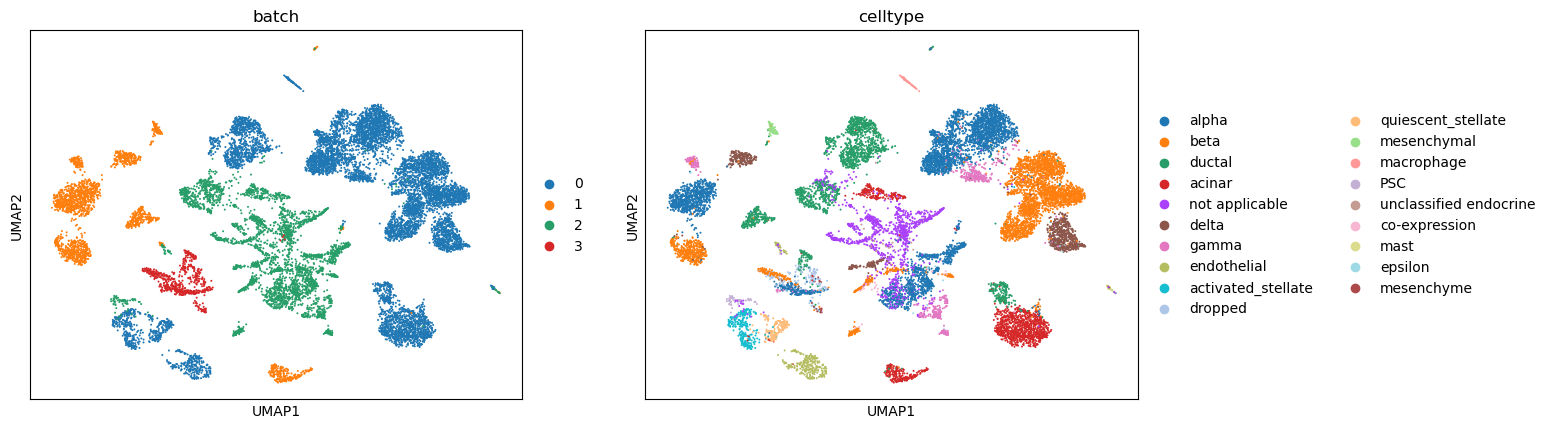

In [7]:
# seeing the batch effect

sc.pp.pca(adata_all)
sc.pp.neighbors(adata_all)
sc.tl.umap(adata_all)
sc.pl.umap(
    adata_all, color=["batch", "celltype"], palette=sc.pl.palettes.vega_20_scanpy
)

In [8]:
# solving the batch effect via BBKNN

sc.external.pp.bbknn(adata_all, batch_key="batch")
### 여기서 checkpoint 안만들어도 되는 이유!
### pp.neighbors와 pp.bbknn은 모두 X 보고 cell-cell graph 만드는 함수임.(obsp 저장)
### 따라서 pp.bbknn을 시행하면 obsp가 overwritten. 

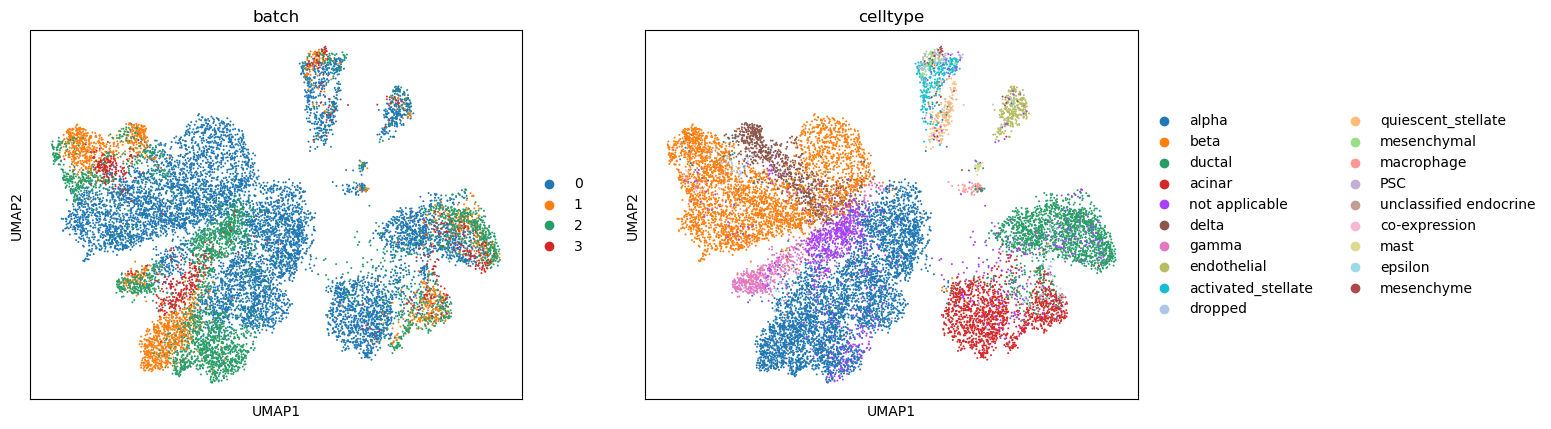

In [9]:
sc.tl.umap(adata_all)
### umap은 obsp의 cell-cell graph를 바탕으로 계산되는 그래프임. adata안에 안들어감
sc.pl.umap(adata_all, color=["batch", "celltype"])

In [2]:
adata_all = sc.read_h5ad("cache/pancreas_adata_all.h5ad")

In [3]:
## 결과가 생각보다 안예쁨. ingest 써야 함

## 일단 batch 0을 ref로 삼아 하나씩 합친다

adata_ref = adata_all[adata_all.obs["batch"] == "0"].copy()

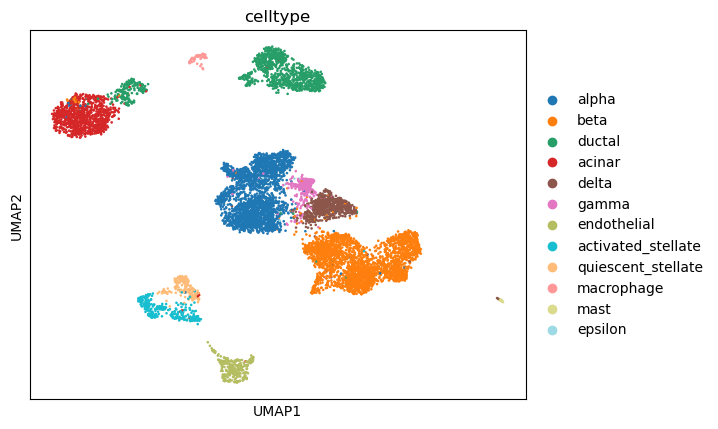

In [4]:
sc.pp.pca(adata_ref)
sc.pp.neighbors(adata_ref)
sc.tl.umap(adata_ref)
sc.pl.umap(adata_ref, color="celltype")

In [5]:
adatas = [adata_all[adata_all.obs["batch"] == i].copy() for i in ["1", "2", "3"]]

In [6]:
sc.settings.verbosity = 2

for iadata, adata in enumerate(adatas, 1):
    print(f"... integrating batch {iadata}")
    adata.obs["celltype_orig"] = adata.obs["celltype"]  # save the original cell type
    sc.tl.ingest(adata, adata_ref, obs="celltype")

... integrating batch 1
running ingest


/root/miniconda/envs/unified_env/lib/python3.10/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


    finished (0:00:06)
... integrating batch 2
running ingest


/root/miniconda/envs/unified_env/lib/python3.10/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


    finished (0:00:04)
... integrating batch 3
running ingest


/root/miniconda/envs/unified_env/lib/python3.10/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


    finished (0:00:01)


In [8]:
adata_concat = ad.concat([adata_ref, *adatas], label="batch", join="outer")

In [10]:
adata_concat.obs["celltype"] = (
    adata_concat.obs["celltype"]
    .astype("category")
    .cat.reorder_categories(adata_ref.obs["celltype"].cat.categories)
)

adata_concat.uns["celltype_colors"] = adata_ref.uns["celltype_colors"]

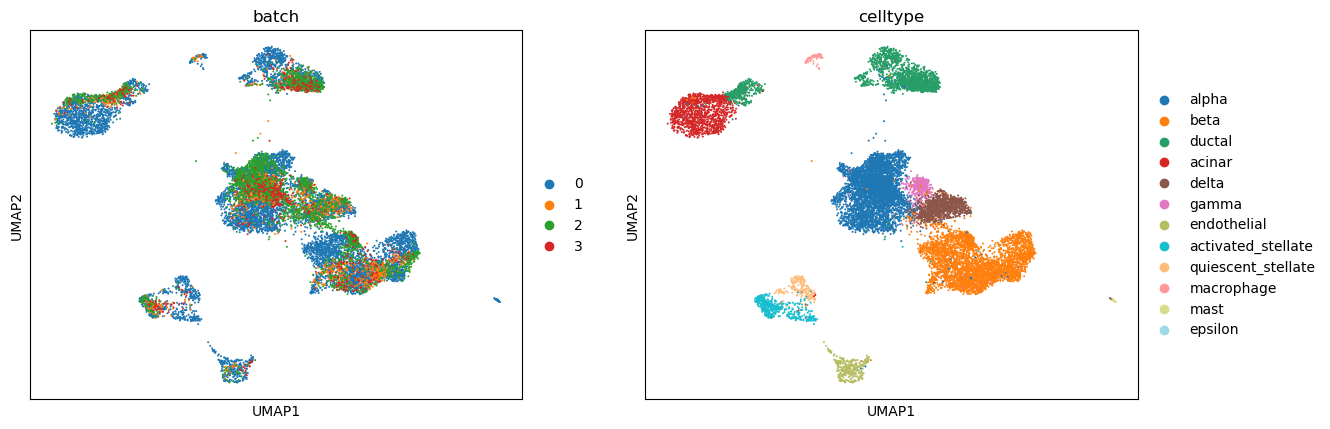

In [11]:
sc.pl.umap(adata_concat, color=["batch", "celltype"])

In [12]:
adata_concat.write("cache/pancreas_adata_concat.h5ad")

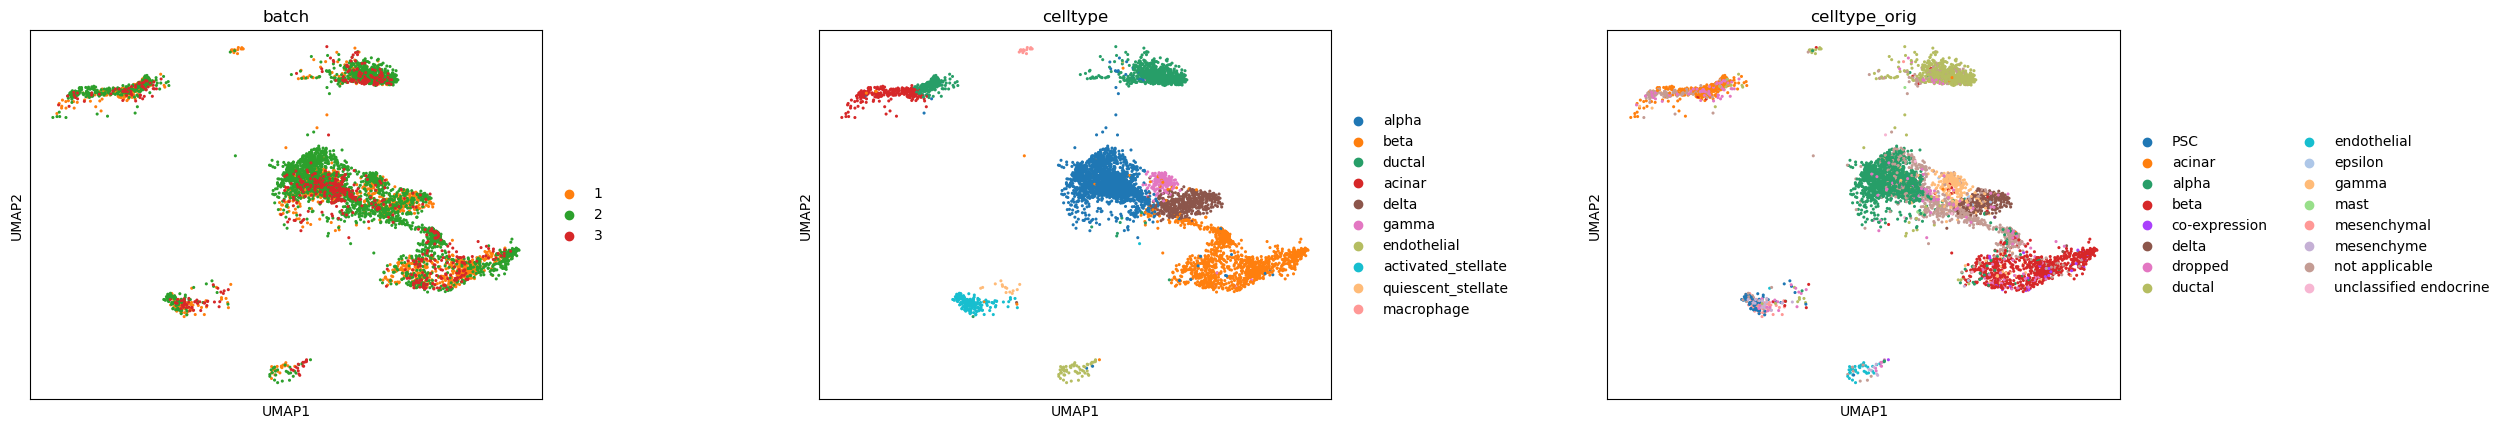

In [13]:
# evaluating consistency

adata_query = adata_concat[adata_concat.obs["batch"].isin(["1", "2", "3"])].copy()
sc.pl.umap(adata_query, color=["batch", "celltype", "celltype_orig"], wspace=0.4)\

## The following plot is a bit hard to read, hence, move on to confusion matrices below.

In [16]:
# Cell types conserved across batches

# find intersected categories
### Find categories shared between two annotations
conserved_categories = adata_query.obs["celltype"].cat.categories.intersection(
    adata_query.obs["celltype_orig"].cat.categories
)
### "celltype" : predicted or transferred, "celltype_orig" : original or ground truth
### give labels that appear both

# intersect categories
obs_query_conserved = adata_query.obs.loc[
    adata_query.obs["celltype"].isin(conserved_categories)
    & adata_query.obs["celltype_orig"].isin(conserved_categories)
].copy()
### intersect categories in celltype/celltype_orig that is in conserved_categories

# remove unused categories in labeled categories
obs_query_conserved["celltype"] = obs_query_conserved["celltype"].cat.remove_unused_categories()

# remove unused categories and fix category ordering in given categories
obs_query_conserved["celltype_orig"] = (
    obs_query_conserved["celltype_orig"]
    .cat.remove_unused_categories()
    .cat.reorder_categories(obs_query_conserved["celltype"].cat.categories)
)

In [17]:
pd.crosstab(obs_query_conserved["celltype"], obs_query_conserved["celltype_orig"])

### cross table (confusion matrix)의 대각선이 두껍게 나올수록, 
### celltype (ref에 의해 추측된 label)과 celltype_orig (원래 label)이 비슷하다는 뜻
### 만약 off-orthogonal한 항목이 많다면, reference transfer과정에서 잘못된 mapping이 많았다
### = ingest가 해당 query에 적합하지 않다. 

## 결과 : ductal cell 제외하고는 다 잘 mapping됨

celltype_orig,alpha,beta,ductal,acinar,delta,gamma,endothelial
celltype,,,,,,,
alpha,1814,3,16,1,1,20,0
beta,53,805,6,1,11,35,0
ductal,7,5,681,241,0,0,0
acinar,2,3,3,165,0,3,0
delta,6,3,2,0,304,71,0
gamma,1,5,0,1,0,187,0
endothelial,2,0,0,0,0,0,36


In [18]:
pd.crosstab(adata_query.obs["celltype"], adata_query.obs["celltype_orig"])

### 이번엔 intersection이 아니라 모든 cell들을 봄
### 전체적인 mapping에서 어디가 어떻게 잘못 mapping되었는지 볼 수 있음. 

celltype_orig,PSC,acinar,alpha,beta,co-expression,delta,dropped,ductal,endothelial,epsilon,gamma,mast,mesenchymal,mesenchyme,not applicable,unclassified endocrine
celltype,,,,,,,,,,,,,,,,
alpha,0,1,1814,3,2,1,40,16,0,3,20,7,0,0,312,10
beta,1,1,53,805,37,11,41,6,0,0,35,0,0,1,522,24
ductal,0,241,7,5,0,0,37,681,0,0,0,0,2,0,94,0
acinar,0,165,2,3,0,0,23,3,0,0,3,0,0,0,90,0
delta,0,0,6,3,0,304,13,2,0,6,71,0,0,0,95,7
gamma,0,1,1,5,0,0,2,0,0,1,187,0,0,0,15,0
endothelial,1,0,2,0,0,0,6,0,36,0,0,0,0,6,7,0
activated_stellate,48,1,1,3,0,0,11,6,0,0,0,0,78,20,17,0
quiescent_stellate,4,0,1,1,0,0,5,1,1,0,0,0,0,0,1,0


In [19]:
# density plot : 전체 plot에서 각 batch가 얼마나 차지하는지 봄

sc.tl.embedding_density(adata_concat, groupby="batch")

computing density on 'umap'


In [22]:
sc.settings.figdir = "./plots_tutorial"

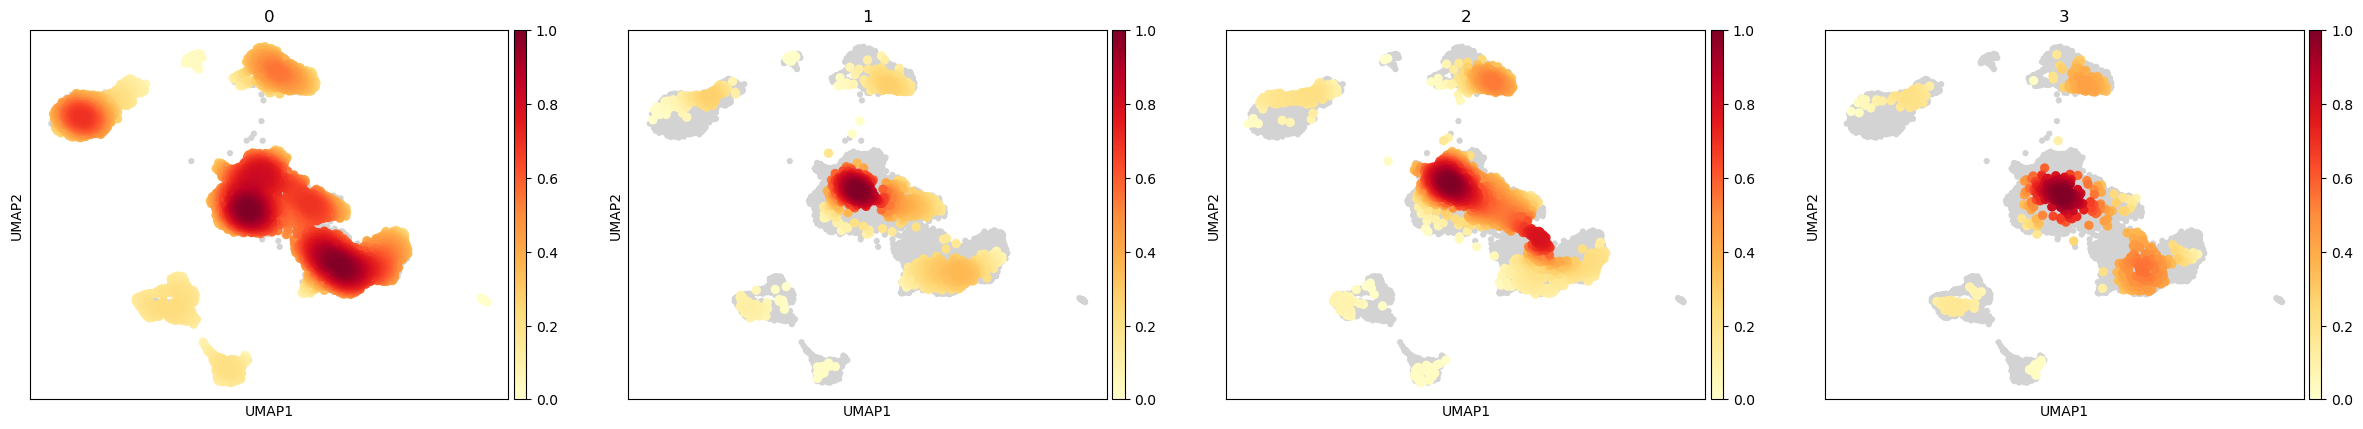

In [23]:
sc.pl.embedding_density(adata_concat, groupby="batch", save = "pancreas_density_plot")

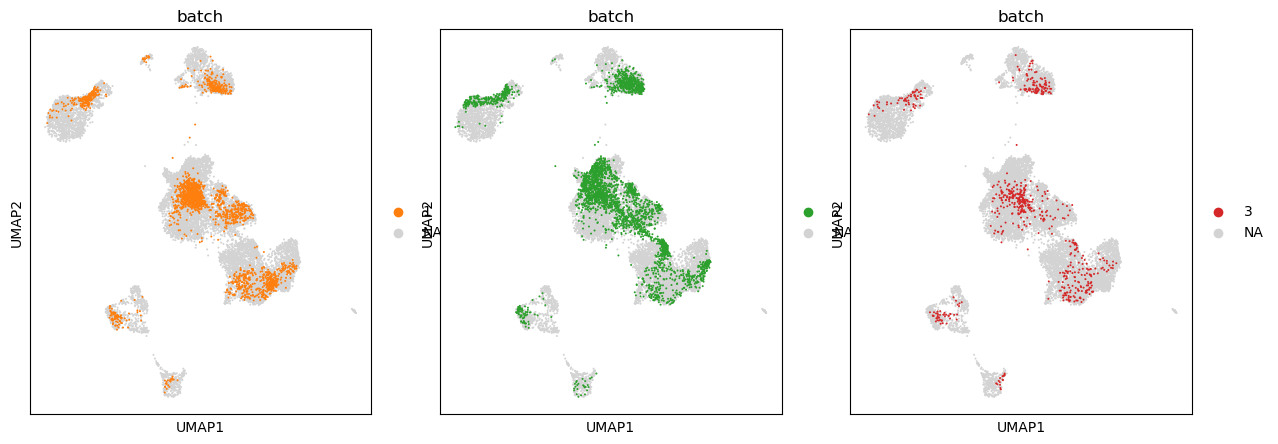

In [21]:
import matplotlib.pyplot as plt

fig, axes = plt.subplots(1, 3, figsize=(15, 5))
for batch, ax in zip(["1", "2", "3"], axes):
    sc.pl.umap(adata_concat, color="batch", groups=[batch], ax=ax, show=False)

In [14]:
adata_all.write("cache/pancreas_adata_all.h5ad")